In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import random
import itertools
import datetime
import pytz
from pytz import timezone

First, let's read in the data. Because of its large size, we have to use chunksize with pd.concat in order to read everything. However, that takes a long time, and the dataframe is too big to be saved in one chunk. Instead, we try using HDF5 to store and read our dataframe efficiently. We will be working with the first day's overall data, as well as all of the positive samples we have so far.

In [68]:
#Initial csv reading
#df = pd.concat(pd.read_json('data/combined_day1', lines=True, chunksize=100000))
#df_pos.to_csv('data/positives.csv', index=False)

#Open our hdf files
df_store = pd.HDFStore('data/combined_day1.h5')
pos_store = pd.HDFStore('data/positives.h5')

#Save our dataframes as hdf5
#df_store['df'] = df
#pos_store['df'] = df_pos 

#Load out dataframes
df_pos = pos_store['df'] 
df = df_store['df']

#Close our hdf files
pos_store.close()
df_store.close()

#the combined dataset has more features than our day 1, we will take out these extra features
df_pos = df_pos.drop([c for c in df_pos.columns if c not in df.columns], axis=1)

Now let's do some low level preprocessing. Any rows where c_cnt is NaN must be removed as they are useless. Any columns that contain only one unique value give no information, and so are dropped. We keep a record of all the columns that we will drop and their reason for being dropped, and we drop them all at the end.

In [54]:
todrop = {} #key is the column, value is the reason

#Drop all rows where c_cnt is NaN
df = df[np.isfinite(df['c_cnt'])]
#Drop all columns where nunique() == 1
for c in df.columns:
    try:
        if df[c].nunique() < 2:
            todrop[c] = 'Only has 1 unique value'
    except:
        pass

Let's take a look at the columns in terms of their non-NaN values for our overall positive sampleset and the first day's dataset.

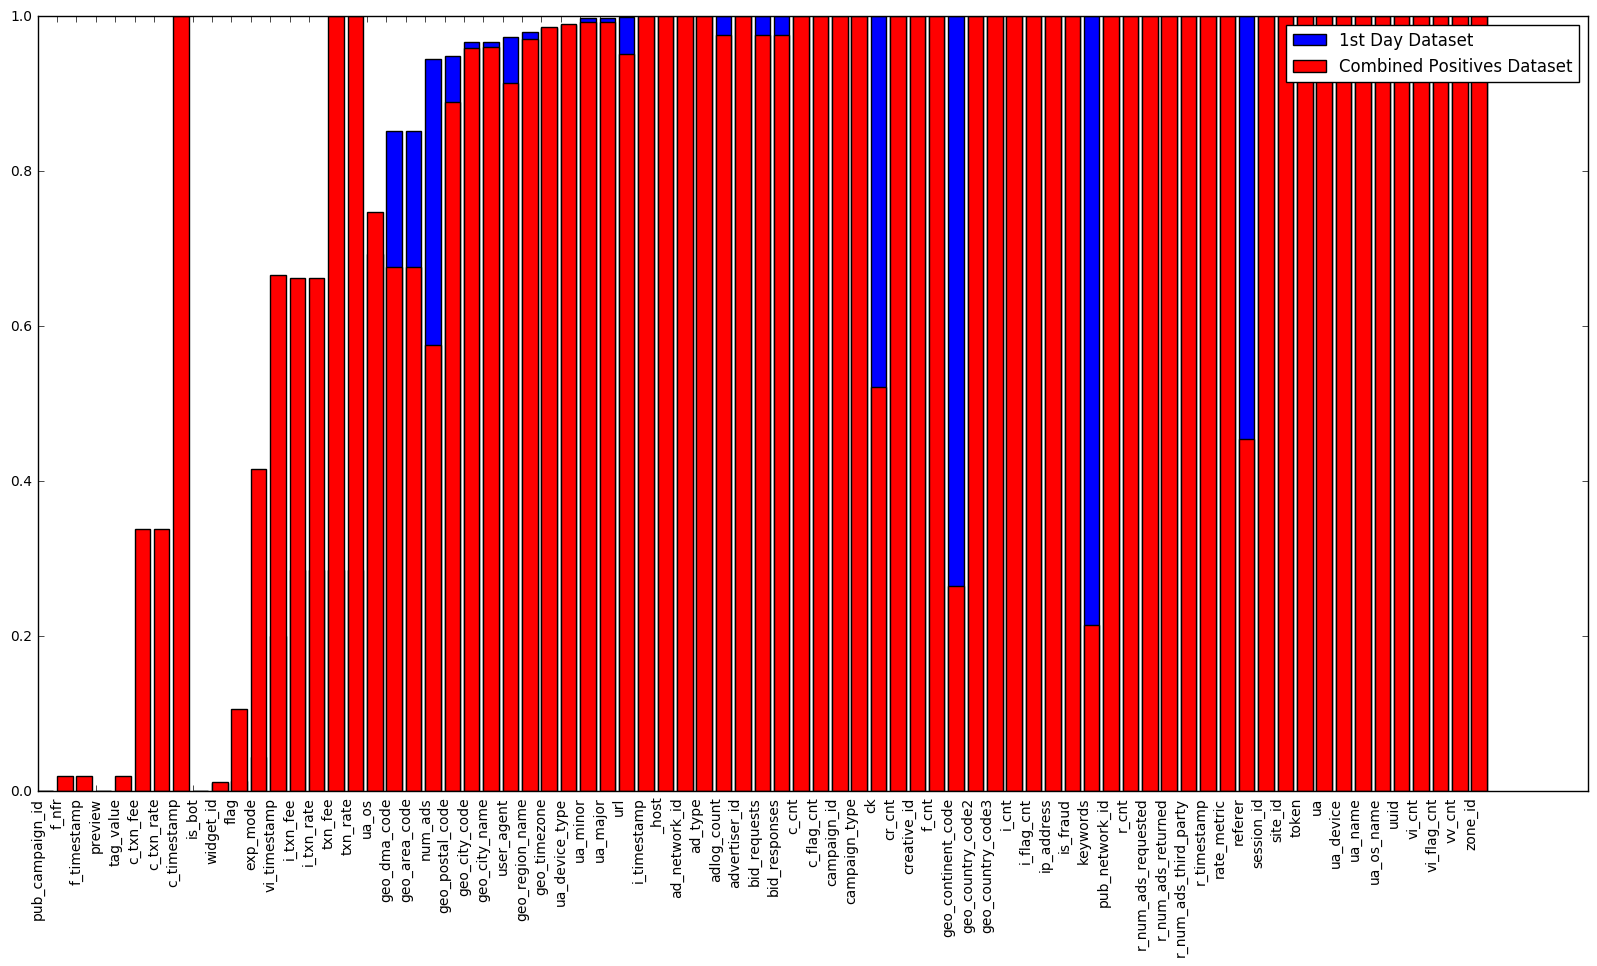

In [41]:
countx, county_df = [c for c in df.columns], [df[c].count()/df.shape[0] for c in df.columns] 
#sort them by 1st day dataframe's non-NaN count
countx = [x for _, x in sorted(zip(county_df, countx))]
county_pos = [df_pos[c].count()/df_pos.shape[0] for c in countx]
county_df = sorted(county_df)
plt.figure(figsize=(20,10))
plt.bar([i for i in range(len(countx))], county_df, color='b', label='1st Day Dataset')
plt.bar([i for i in range(len(countx))], county_pos, color='r', label='Combined Positives Dataset')
plt.xticks([i for i in range(len(countx))], countx, rotation=90)
plt.legend()
plt.show()

This graph is a problem for us. It seems that positive samples are inconsistent with NaN distributions across the regular dataset. It is easy for us to remove the first few features that consists of 30%+ NaNs. However, geo_dma_code, geo_area_code, num_ads, ck, geo_continent_code, keywords, and referer have much more NaNs in the combined positive dataset than the regular dataset. 

Upon further inspection, this is what I found for these features - 

Keywords is consistently blank across the overall dataset, which is why its not showing up as NaN - we will be constructing our own keywords with urls anyways, so we can just drop this feature.

We can reconstruct geo_continent code with geo_country code, so its not too big of an issue.

We can keep referer, as we will be deconstructing it to create a new feature anyway.

The rest of the features should be able to be dropped without too big of a loss of information.

In [55]:
#drop columns that are more than 30% NaN populated for either overall dataset or combined positives dataset
for c in df.columns:
    if c in todrop:
        continue
    if df_pos[c].count()/df_pos.shape[0] < 0.8:
        todrop[c] = "More than 20% NaNs in combined positive dataset"
    elif df[c].count()/df.shape[0] < 0.8:
        todrop[c] = "More than 20% NaNs in overall dataset"

In [58]:
#These are the features that we will deconstruct with feature engineering, so its ok if it's NaN - just treat as a blank
keep_nans = ['referer', 'url']
for i in keep_nans:
    if i in todrop:
        del todrop[i]
for i in todrop:
    print(i, todrop[i])

geo_area_code More than 20% NaNs in combined positive dataset
ck More than 20% NaNs in combined positive dataset
preview Only has 1 unique value
f_timestamp More than 20% NaNs in combined positive dataset
i_txn_fee More than 20% NaNs in combined positive dataset
is_fraud Only has 1 unique value
geo_continent_code More than 20% NaNs in combined positive dataset
pub_campaign_id Only has 1 unique value
c_txn_rate More than 20% NaNs in combined positive dataset
c_txn_fee More than 20% NaNs in combined positive dataset
vi_timestamp More than 20% NaNs in combined positive dataset
txn_fee More than 20% NaNs in overall dataset
f_nfr Only has 1 unique value
r_num_ads_third_party Only has 1 unique value
geo_dma_code More than 20% NaNs in combined positive dataset
txn_rate More than 20% NaNs in overall dataset
tag_value Only has 1 unique value
cr_cnt Only has 1 unique value
is_bot Only has 1 unique value
widget_id More than 20% NaNs in combined positive dataset
c_timestamp More than 20% NaNs in o

Before we start removing all samples that contain NaN values, we must first consider the effect this will have on our data. We have a TON of negative classes - so really, we just want to preserve as many positive samples as possible. Below, for each column, we find how many NaN instances of that column exists in positive samples, as well as how many NaN instances of that column exists in total. The resulting plot and code is below. 

In [72]:
df_pos = df_pos.drop([c for c in todrop], axis=1)
df_pos = df_pos.dropna(subset=[c for c in df_pos.columns if c not in keep_nans])

df = df.drop([c for c in todrop], axis=1)
df = df.dropna(subset=[c for c in df.columns if c not in keep_nans])

print(df_pos.shape)
print(df.shape)

(8147, 46)
(1570215, 46)


Some final preprocessing - We turn timestamps into individual hours, and all NaN values in referer and url columns into empty strings. Finally, we save our dataframes so we don't have to do this again next time.

In [96]:
#gets hour from timestamp
def timestamp_to_hour(timestamp, is_hour=True):
    if is_hour:
        return timestamp.split(':')[0][-2:]
    else: 
        return timestamp.split(':')[1]
    
def replace_NaN_with_empty_string(val):
    if (isinstance(val, float) and math.isnan(val)) or val == None:
        return ""
    return val
    
for c in df.columns:
    if c.endswith('timestamp'):
        df[c] = df[c].apply(timestamp_to_hour)
        df_pos[c] = df_pos[c].apply(timestamp_to_hour)
    if c in keep_nans:
        df[c] = df[c].apply(replace_NaN_with_empty_string)
        df_pos[c] = df_pos[c].apply(replace_NaN_with_empty_string)



In [97]:
#Double check that there are no more NaN values
for c in df.columns:
    print(c, df.shape[0]-df[c].count(), df_pos.shape[0]-df_pos[c].count())
    if df.shape[0]-df[c].count() > 0 or df_pos.shape[0] - df_pos[c].count() > 0:
        raise("Fuck")

#Open our hdf files
df_store = pd.HDFStore('data/combined_day1_processed.h5')
pos_store = pd.HDFStore('data/positives_processed.h5')

#Save our dataframes as hdf5
df_store['df'] = df
pos_store['df'] = df_pos 

#Close our hdf files
pos_store.close()
df_store.close()

_host 0 0
ad_network_id 0 0
ad_type 0 0
advertiser_id 0 0
bid_requests 0 0
bid_responses 0 0
c_cnt 0 0
c_flag_cnt 0 0
campaign_id 0 0
campaign_type 0 0
creative_id 0 0
f_cnt 0 0
geo_city_code 0 0
geo_city_name 0 0
geo_country_code2 0 0
geo_country_code3 0 0
geo_postal_code 0 0
geo_region_name 0 0
geo_timezone 0 0
i_cnt 0 0
i_flag_cnt 0 0
i_timestamp 0 0
ip_address 0 0
pub_network_id 0 0
r_cnt 0 0
r_num_ads_requested 0 0
r_num_ads_returned 0 0
r_timestamp 0 0
rate_metric 0 0
referer 0 0
session_id 0 0
site_id 0 0
token 0 0
ua 0 0
ua_device 0 0
ua_device_type 0 0
ua_major 0 0
ua_minor 0 0
ua_name 0 0
ua_os_name 0 0
url 0 0
user_agent 0 0
uuid 0 0
vi_cnt 0 0
vi_flag_cnt 0 0
zone_id 0 0


/Users/jihan/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['_host', 'ad_type', 'bid_requests', 'bid_responses', 'campaign_type', 'geo_city_name', 'geo_country_code2', 'geo_country_code3', 'geo_postal_code', 'geo_region_name', 'geo_timezone', 'i_timestamp', 'ip_address', 'r_timestamp', 'rate_metric', 'referer', 'session_id', 'token', 'ua', 'ua_device', 'ua_device_type', 'ua_name', 'ua_os_name', 'url', 'user_agent', 'uuid']]

  exec(code_obj, self.user_global_ns, self.user_ns)
